# __MODELO DE PREDICCIÓN DEL JCR__

El notebook de Jupyter que se presenta tiene como objetivo crear un __modelo de predicción__ mediante __regresión__ para el JCR de las revistas más actuales en el campo de _Artificial Intelligence_ (_Computer Science_). 

### __IMPORTS__

A lo largo del notebook, se necesitará importar las siguientes librerías:

In [1]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.ensemble import StackingRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR, LinearSVR

from sklearn.model_selection import GridSearchCV, RepeatedKFold
from sklearn.metrics import mean_squared_error

### __DATASET__

Para poder ejecutar este notebook, será necesario tener los siguientes ficheros (en el mismo directorio del notebook):
* jcr_esperado.csv: Contine los valores del JCR de años previos
* diferencias.csv: Contiene las diferencias entre el JCR real y el JCR obtenido por la alumna 
* citas.csv: Contine el núemro de citas obtenidas por cada revista

__NOTA__: Estos ficheros se pueden obtener ejecutando el _script_ de Python __calcJCR.py__.

In [2]:
# Lectura de datos
try:
    df_jcr = pd.read_csv("jcr_esperado.csv")
    df_citas = pd.read_csv("citas.csv")
    df_diferencias = pd.read_csv("diferencias.csv")
except FileNotFoundError:
    print("Error: no se pudo cargar uno o más archivos de datos.")
    exit()

### __DATOS PARA EL ENTRENAMIENTO DEL MODELO__

Para poder entrenar nuestro modelo, se emplearán los datos obtenidos desde 2018 hasta 2021. Se tratará de predecir el JCR del último año (2021).

In [3]:
# Seleccionar columnas de 2018 a 2021 junto con la columna de Revista
anio_i = 2018
anio_f = 2021 + 1
df_jcr1 = df_jcr.loc[:, ['Revista'] + [f'JCR {anio}' for anio in range(anio_i,anio_f+1,1)]]
df_citas1 = df_citas.loc[:, ['Revista'] + [f'Citas {anio}' for anio in range(anio_i,anio_f+1,1)]]
df_diferencias1 = df_diferencias.loc[:, ['Revista'] + [f'Diff {anio}' for anio in range(anio_i,anio_f+1,1)]]

# Unión de los datos en función de la revista
df1 = pd.merge(df_jcr1, df_citas1, on="Revista")
df1 = pd.merge(df1, df_diferencias1, on="Revista")

In [4]:
# Separar los datos en conjunto de entrenamiento y prueba
X = df1.drop(columns=["Revista", f"Diff {anio_f-1}", f"JCR {anio_f-1}"])
y = df1[f"JCR {anio_f-1}"]


### __TRATAMIENTO DE LOS DATOS__

Dado que el _dataset_ en cuestión tiene _missing values_, se prueban distintas formas de reemplazarlos.

In [5]:
# Comprobamos si hay missing values en nuestros datos 

# Verificar si hay valores faltantes en X
if X.isnull().values.any():
    print("Hay missing values en X")

# Verificar si hay valores faltantes en y
if y.isnull().values.any():
    print("Hay missing values en y")


Hay missing values en X


In [6]:
from sklearn.impute import SimpleImputer, KNNImputer

"""
+------+
| NOTA | La mediana da resultados mucho mejores que la media.
+------+
"""
carryOn = True

while carryOn:
    estrategia = int(input("Seleccione la estrategia de imputación deseada:\n 1 - Media\n 2 - Mediana\n"))
   
    # Seleccionar estrategia -> crear imputador
    if estrategia == 1:
        # utilizando la media
        X = X.fillna(X.mean()).values
        y = y.fillna(y.mean()).values
        carryOn = False
    elif estrategia == 2:
        # utilizando la mediana
        X = X.fillna(X.median()).values
        y = y.fillna(y.median()).values   
        carryOn = False
    else:
        print("Estrategia no válida.")


if np.isnan(X).any() or np.isnan(y).any():
    print("No se han eliminado los missing values correctamente.")
else:
    print("Se han eliminado los missing values correctamente.")
    


Se han eliminado los missing values correctamente.


### __ESTIMADORES__

Para resolver este problema de regresión, se han seleccionado diferentes modelos. De entre todos ellos, se elegirá el que mejores resultados obtenga. 


In [7]:
seed = 42
estimators = [('xbr', XGBRegressor(random_state=seed)), ('randomfor', RandomForestRegressor(random_state=seed))]

models = [  
        ("Linear Regression", LinearRegression(),
            {# Parámetros a seleccionar
            'fit_intercept': [True, False]
            }         
        ),
        
        ("Random Forest", RandomForestRegressor(random_state=seed), 
            { # Parámetros a seleccionar
            "n_estimators": [50, 100, 150, 200, 300, 400, 500], # Nº de árboles -> 200 - 500
            "max_depth": [10, 20, 30, 40, 50] # Profundidad
            }
        ),
        
        ("XGB Regressor", XGBRegressor(random_state=seed), 
                {# Parámetros a seleccionar
                 'tree_method' : ["hist","exact", "approx"],
                 'learning_rate': [0.1, 0.2, 0.3, 0.4],
                 'max_depth': [4, 6, 8 , 10, 12]
                }           
        ),
                
        ("MLP", MLPRegressor(random_state=seed),
            { # Parámetros a seleccionar
            'max_iter' : [ 6500, 7000, 7500],  # iteraciones
            'alpha': [ 0.1, 0.2, 0.3], # Coeficiente de regularización
            'learning_rate_init': [0.0001, 0.0007, 0.001] # Tasa de aprendizaje 
            }
        ),
        
        ("SVM", SVR(),
            {# Parámetros a seleccionar
            # 'max_iter' : [ 6500, 7000, 7500],  # iteraciones
            'C': [ 10, 20, 30, 40, 50], # parámetro de regularización -> penalización de errores
            'gamma': [0.000001, 0.00001, 0.0001] # coeficiente del núcleo
            }
        ),        ,
        
        ("Stacking Regressor", StackingRegressor(estimators = estimators),
         {# Parámetros a seleccionar
          "randomfor__n_estimators": [200, 300, 400, 500],
          "randomfor__max_depth": [10, 20, 30, 40],
          'xbr__learning_rate': [0.2, 0.3, 0.4]
         }
        )      

        # TODO: Meter el resto de modelos AQUÍ ...          
        ]

### __VALIDACIÓN CRUZADA ANIDADA__

Se ha elegido el método de validación cruzada anidada (_nested cross validation_) para resolver el problema en cuestión debido a sus ventajas en la evaluación del modelo y la selección de hiperparámetros. _Nested cross validation_ se utiliza para estimar el rendimiento de un modelo de aprendizaje automático y su capacidad para generalizar a nuevos datos. A diferencia de la validación cruzada tradicional, que utiliza una sola partición de los datos para la selección de hiperparámetros, nested cross validation utiliza múltiples particiones para evaluar la capacidad del modelo para generalizar. De esta manera, se pueden obtener estimaciones más precisas del rendimiento del modelo y evitar la sobreoptimización de los hiperparámetros.

In [8]:
""" Definir los objetos para la NESTED CROSS VALIDATION """
inner_cv = RepeatedKFold(n_splits=2, n_repeats=5, random_state=10)
outer_cv = RepeatedKFold(n_splits=2, n_repeats=5, random_state=11)

In [9]:
# Para cada modelo...
results = {}
rmse_scores = []
parametros = []
for nombre, estimator, param_grid in models:
    
    """ OUTER LOOP """
    # Iterar a través de los splits del RepeatedKFold externo
    for train_index, test_index in outer_cv.split(X):

        # Dividir los datos X e y en train y test para este split
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        """ INNER LOOP """
        # Realizar el GridSearchCV con los datos de entrenamiento y el espacio de búsqueda definido
        grid_search = GridSearchCV(estimator=estimator, param_grid=param_grid, cv=inner_cv, scoring='neg_mean_squared_error')
        grid_search.fit(X_train, y_train)

        # Obtener el mejor modelo y predecir con los datos de test
        best_param = grid_search.best_params_
        parametros.append(best_param)
        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        # Calcular el RMSE y agregarlo a la lista de scores
        rmse_score = mean_squared_error(y_test, y_pred, squared=False)
        rmse_scores.append(rmse_score)
           
    # Imprimir los resultados  :.2f
    print(f'[Modelo "{nombre}"]')
    print(f'Valores de RMSE: {rmse_scores}')
    print(f'Media RMSE: {np.mean(rmse_scores)}')
    
    """ GUARDAR RESULTADOS """
    # Se guardarán en forma de diccionario
    results[nombre] = {"param" : parametros, "rmse" : np.mean(rmse_scores), "rmse_list" : rmse_scores} 


[Modelo "Linear Regression"]
Valores de RMSE: [17.048725805193122, 3.2152026203631077, 18.342587829628354, 3.6569261110172353, 3.296400014089166, 2.9579761573563714, 3.5623465265698537, 2.8304099347352896, 15.991254535428556, 2.818385965459316]
Media RMSE: 7.372021549984036
[Modelo "Random Forest"]
Valores de RMSE: [17.048725805193122, 3.2152026203631077, 18.342587829628354, 3.6569261110172353, 3.296400014089166, 2.9579761573563714, 3.5623465265698537, 2.8304099347352896, 15.991254535428556, 2.818385965459316, 3.4438796623196635, 3.446154739442255, 3.749536161118117, 3.072144203083766, 3.083729875042169, 3.6651746397106835, 4.2926097932145435, 2.8661609109479254, 3.524622984203407, 3.139895964707643]
Media RMSE: 5.400206221681527
[Modelo "XGB Regressor"]
Valores de RMSE: [17.048725805193122, 3.2152026203631077, 18.342587829628354, 3.6569261110172353, 3.296400014089166, 2.9579761573563714, 3.5623465265698537, 2.8304099347352896, 15.991254535428556, 2.818385965459316, 3.4438796623196635,

Se guardarán los resultados en un fichero CSV.

In [14]:
import csv

# Abre el archivo CSV en modo escritura
with open('resultados.csv', 'w', newline='') as file:

    # Crea el objeto escritor CSV
    writer = csv.writer(file)

    # Escribe el encabezado
    writer.writerow(['Modelo', 'Parametros', 'RMSE'])

    # Itera sobre los resultados y escribe cada fila
    for nombre, resultado in results.items():
        for i in range(len(resultado['rmse_list'])):
            writer.writerow([nombre, resultado['param'][i], resultado['rmse_list'][i]])


### __GRAFICAR RESULTADOS__

Finalmente, se realiza una comparativa entre los diferentes modelos a través de una gráfica.

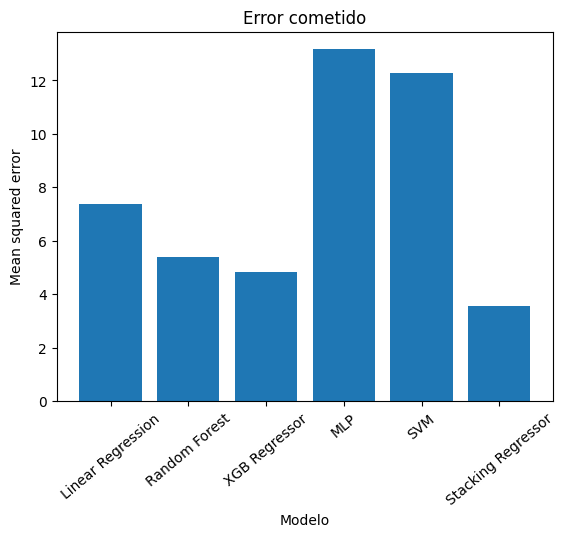

In [15]:
import matplotlib.pyplot as plt

# Obtener los nombres y puntajes de los resultados
nombres = []
scores = []
scores_list = []
for nombre, result in results.items():
    nombres.append(nombre)
    scores.append(result["rmse"]) # Mean squared error
    scores_list.append(result["rmse_list"])
    

# Crear la gráfica de barras
plt.bar(nombres, scores)

# Configurar el título y los ejes
plt.title("Error cometido")
plt.xlabel("Modelo")
plt.ylabel("Mean squared error")

# Mostrar la gráfica
plt.xticks(rotation=40)
plt.show()



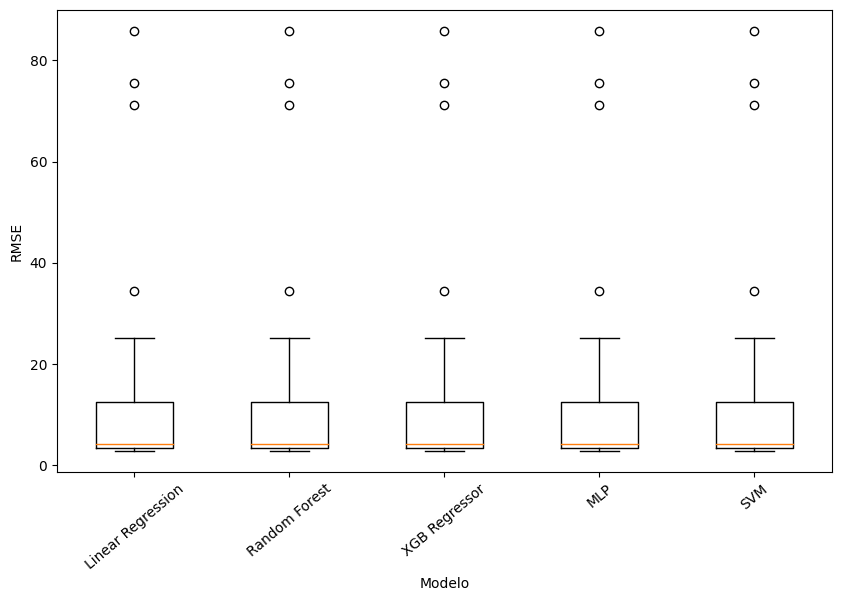

In [13]:
# Crear un diccionario con los valores de RMSE para cada modelo
rmse_dict = {nombre: scores_list[i] for i, nombre in enumerate(nombres)}

# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(10,6))

# Crear el diagrama de cajas
ax.boxplot(rmse_dict.values())

# Configurar los ticks y etiquetas de los ejes
ax.set_xticklabels(rmse_dict.keys())
plt.xticks(rotation=40)
plt.xlabel("Modelo")
plt.ylabel("RMSE")

# Mostrar el diagrama de cajas
plt.show()
